# Construction of the training dataset

In [51]:
import sys
import numpy as np
import os
from pathlib import Path
import pandas as pd
import seaborn as sns; sns.set_theme(color_codes=True)
import SureTypeSC as sc
import logging
import SureTypeSC.MachineLearning as MachineLearning
import SureTypeSC.Config as Config
import pickle5 as pickle
from SureTypeSC.DataLoader import Patterns
from itertools import product 
import random
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer

## Loading reference Coriell Family

SNP array data from Coriell Family 774

| Coriell ID | Relationship | Nr of samples | Type |
| --- | --- | --- | --- |
| GM07224 | Mother | 9 | many cells |
| GM07225 | Father | 9 | many cells |
| GM07228 | Proband | 9 | many cells |
| GM07228 | Proband | 58| single cell |

In [6]:
with open('Family_774_validated.pkl', "rb") as fh:
    df = pickle.load(fh)  


We remove intensity only SNPs.

In [7]:
df=df[df.apply(lambda x: 'cnv' not in x['Name'],axis=1)]
df.head()

,Name,Chr,Position,GM07228_SC_21.GType,GM07228_SC_21.Score,GM07228_SC_21.X,GM07228_SC_21.Y,GM07228_SC_21.X Raw,GM07228_SC_21.Y Raw,GM07228_SC_21.Log R Ratio,...,GM07225_gDNA9_3.Log R Ratio,GM07225_gDNA9_3.B Allele Freq,GM07226_gDNA9_3.GType,GM07226_gDNA9_3.Score,GM07226_gDNA9_3.X,GM07226_gDNA9_3.Y,GM07226_gDNA9_3.X Raw,GM07226_gDNA9_3.Y Raw,GM07226_gDNA9_3.Log R Ratio,GM07226_gDNA9_3.B Allele Freq
733,rs1000002,3,183635768,BB,0.890203,0.026420,0.743389,1900,21016,-0.143046,...,0.052969,0.008559,AB,0.890203,0.619853,0.692549,3941,3690,0.416455,0.590599
734,rs1000003,3,98342907,AA,0.032322,0.136529,0.016306,4622,1482,-2.985654,...,0.118039,0.497146,AB,0.935056,0.824841,0.651651,5140,3517,0.184598,0.468456
735,rs10000030,4,103374154,BB,0.776380,0.008436,0.877140,1463,24610,0.940113,...,0.429813,1.000000,BB,0.776380,0.008428,0.611273,346,3237,0.427795,1.000000
736,rs10000037,4,38924330,BB,0.928959,0.017652,0.612762,1588,17499,-0.255599,...,0.221695,1.000000,BB,0.928959,0.030269,0.881168,499,4526,0.274147,1.000000
737,rs10000041,4,165621955,AA,0.895708,1.432965,0.076658,41027,3449,0.164868,...,-0.101736,0.030972,AA,0.895708,1.261846,0.074833,7651,814,-0.010593,0.014611


And convert dataframe to SureTypeSC's data object that contains multiindexed dataframe and implements aditional operations over it.

In [8]:
dfs=sc.Data.create_from_frame(df)
dfs.df

(293869, 755)
(293869, 752)


individual               gm07224_gdna6_1                              \
feature                    b_allele_freq gtype log_r_ratio     score   
Name       Chr Position                                                
rs1000002  3   183635768        1.000000    BB    0.308357  0.890203   
rs1000003  3   98342907         0.499486    AB    0.120272  0.935056   
rs10000030 4   103374154        1.000000    BB    0.233122  0.776380   
rs10000037 4   38924330         1.000000    BB    0.284010  0.928959   
rs10000041 4   165621955        0.534424    AB    0.176972  0.895708   
...                                  ...   ...         ...       ...   
rs9999883  4   870669           0.998842    BB    0.034009  0.784420   
rs9999908  4   53623449         0.992441    BB   -0.075280  0.887285   
rs9999944  4   148376995        0.987862    BB   -0.053068  0.907843   
rs9999954  4   1893628          1.000000    BB    0.116961  0.862147   
rs9999963  4   84072737         0.010008    AA   -0.024160  0.895308   

individual                                                 gm07224_gdna6_2  \
feature                          x  x_raw         y  y_raw   b_allele_freq   
Name       Chr Position                                                      
rs1000002  3   183635768  0.021275    802  1.027815   8941        1.000000   
rs1000003  3   98342907   0.763532   9933  0.655747   5884        0.475129   
rs10000030 4   103374154  0.022517    745  0.511531   4581        1.000000   
rs10000037 4   38924330   0.025413    834  0.890877   7785        1.000000   
rs10000041 4   165621955  0.796357  10344  0.690706   6183        0.523533   
...                            ...    ...       ...    ...             ...   
rs9999883  4   870669     0.013742    816  1.324858  11569        0.997941   
rs9999908  4   53623449   0.019392    783  0.614283   5537        1.000000   
rs9999944  4   148376995  0.047021   1154  1.266535  10960        0.997175   
rs9999954  4   1893628    0.012709    701  0.606129   5467        1.000000   
rs9999963  4   84072737   1.123326  14300  0.054071    844        0.003318   

individual                      ... gm07228_sc_401        gm07228_sc_402  \
feature                  gtype  ...              y  y_raw  b_allele_freq   
Name       Chr Position         ...                                        
rs1000002  3   183635768    BB  ...       0.180701   2253       0.699230   
rs1000003  3   98342907     AB  ...       0.093814   1629       0.000000   
rs10000030 4   103374154    BB  ...       0.830068   6682       1.000000   
rs10000037 4   38924330     BB  ...       1.081188   8482       1.000000   
rs10000041 4   165621955    AB  ...       0.172442   2258       0.052998   
...                        ...  ...            ...    ...            ...   
rs9999883  4   870669       BB  ...       1.137275   8657       0.996891   
rs9999908  4   53623449     BB  ...       0.784005   6180       1.000000   
rs9999944  4   148376995    BB  ...       1.372669  10568       0.991027   
rs9999954  4   1893628      BB  ...       0.687822   5508       1.000000   
rs9999963  4   84072737     AA  ...       0.061528   1383       0.000893   

individual                                                             \
feature                  gtype log_r_ratio     score         x  x_raw   
Name       Chr Position                                                 
rs1000002  3   183635768    AB   -1.256508  0.345138  0.149370   1420   
rs1000003  3   98342907     AA    0.081584  0.935056  1.210032   8969   
rs10000030 4   103374154    BB    0.885138  0.776380  0.033549    654   
rs10000037 4   38924330     BB    0.392007  0.928959  0.025737    615   
rs10000041 4   165621955    AA    0.326552  0.895143  1.525142  11229   
...                        ...         ...       ...       ...    ...   
rs9999883  4   870669       BB    0.156313  0.784420  0.019724    588   
rs9999908  4   53623449     BB    0.149384  0.887285  0.006389    421   
rs9999944  4   148376995    BB

Check sample counts.

In [9]:
# list of samples in the dataframe

samples=[re.search('(gm[0-9]+)_(gdna|sc).*',i).group(1) for i in dfs.df.loc[:,(slice(None),'gtype')].columns.get_level_values(0)]
types=[re.search('(gm[0-9]+)_(gdna|sc).*',i).group(2) for i in dfs.df.loc[:,(slice(None),'gtype')].columns.get_level_values(0)]

Counter([r for r in zip(samples,types)])

Counter({('gm07224', 'gdna'): 9,
         ('gm07225', 'gdna'): 9,
         ('gm07226', 'gdna'): 9,
         ('gm07228', 'gdna'): 9,
         ('gm07228', 'sc'): 58})

Check naming consistency/kinship of the samples

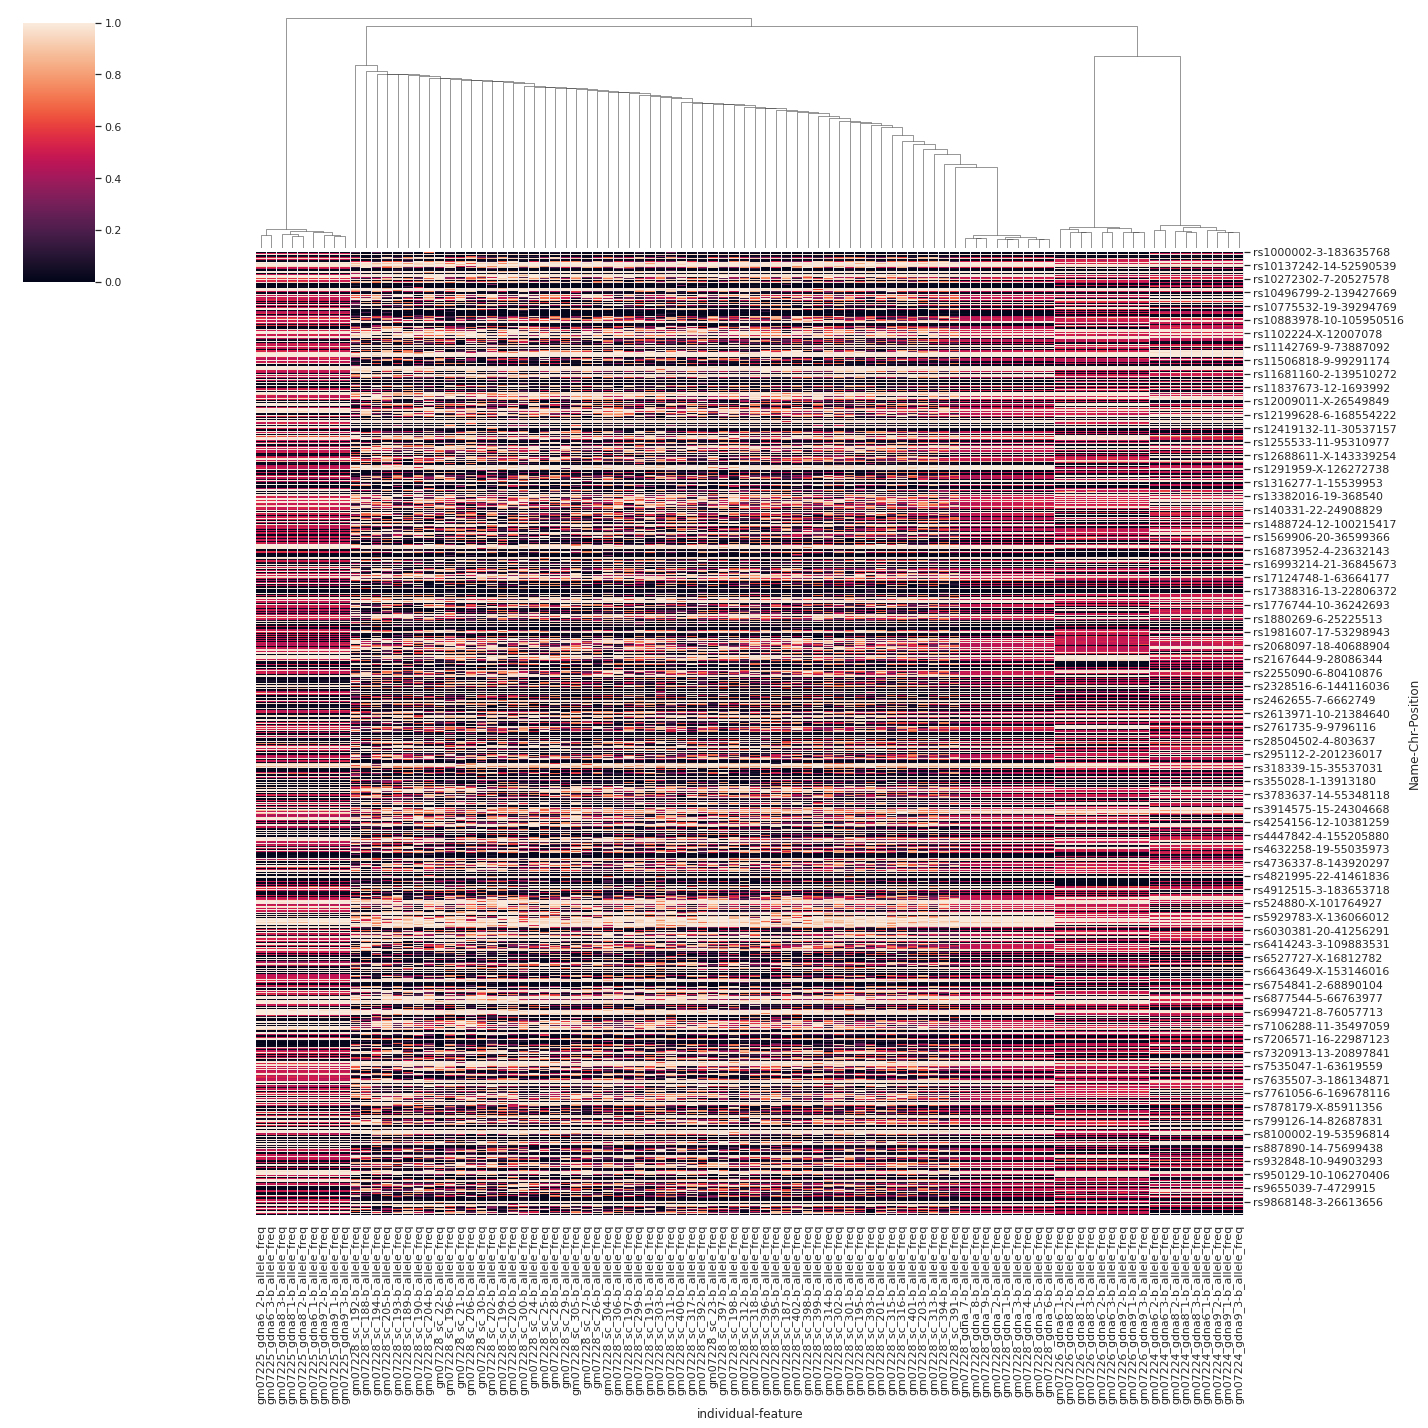

In [10]:
g = sns.clustermap(dfs.df.loc[:,(slice(None),'b_allele_freq')].dropna(),col_cluster=True,row_cluster=False,xticklabels=True,figsize=(20, 20))

Divide Data object based on sample type.

In [11]:
# divide based on type
gdna=dfs.slice('gdna')
scc=dfs.slice('sc')

In [12]:
# apply standard GenCall threshold to gDNA and extract parental and proband gDNA samples
gdna.apply_NC_threshold_3(0.15,inplace=True)
mother=gdna.slice("gm07224")
father=gdna.slice("gm07225")
ref_proband=gdna.slice("gm07228")

Mask out calls that are not concordant across all samples in mother and father.

In [13]:
for d in [mother,father]:
    consistent_calls=(d.df.loc[:,(slice(None),'gtype')].eq(d.consensus_genotype(),axis=0).all(axis=1)) & (d.consensus_genotype()!='NC')
    d.df=d.df.loc[consistent_calls]

In [14]:
_t=pd.concat([mother.consensus_genotype(),father.consensus_genotype()],axis=1)
_t.columns=['mother','father']

_t.value_counts()

mother  father
BB      BB        68834
AA      AA        55285
AB      AB        31136
        BB        27886
BB      AB        26086
AB      AA        25307
AA      AB        23332
BB      AA         9981
AA      BB         9970
NC      NC         7072
        AA         1913
AB      NC         1719
NC      AB         1560
        BB         1520
AA      NC         1179
BB      NC         1089
dtype: int64

In [15]:
mother.consensus_genotype().value_counts()

BB    105990
AA     89766
AB     86048
NC     12065
dtype: int64

In [16]:
father.consensus_genotype().value_counts()

BB    108210
AA     92486
AB     82114
NC     11059
dtype: int64

In [17]:
len(set(father.df.index).intersection(set(mother.df.index)))

277817

## Feature engineering
* m_raw and a_raw - logarithmic transformation of raw intensities (x_raw, y_raw) -  m_raw=log(x_raw/y_raw), a_raw=0.5*log(x_raw*y_raw)
* output - correct vs mistyped SC SNP


In [18]:
for el in [mother,father,scc]:
    el.calculate_transformations_2()
scc.compare_against_reference_lightweight(ref_proband)

individual               gm07228_sc_187                                 \
feature                               a      a_raw b_allele_freq gtype   
Name       Chr Position                                                  
rs1000002  3   183635768      -1.994288  12.197907      0.647485    AB   
rs1000003  3   98342907       -2.845601  11.673862      0.056492    AA   
rs10000030 4   103374154      -3.417125  11.245905      0.908997    BB   
rs10000037 4   38924330       -2.391087  12.208795      0.996551    BB   
rs10000041 4   165621955      -1.664398  12.658596      0.044002    AA   
...                                 ...        ...           ...   ...   
rs9999883  4   870669         -2.591069  12.143466      0.988086    BB   
rs9999908  4   53623449       -4.938073  11.247175      1.000000    BB   
rs9999944  4   148376995      -1.446280  12.999332      0.981092    BB   
rs9999954  4   1893628        -3.042274  11.954695      1.000000    BB   
rs9999963  4   84072737       -2.400568  12.220011      0.008085    AA   

individual                                                                 \
feature                  log_r_ratio         m     m_raw output     score   
Name       Chr Position                                                     
rs1000002  3   183635768   -0.924901 -0.448626 -0.165727   True  0.803444   
rs1000003  3   98342907    -1.454229  2.995562  2.362014   True  0.341942   
rs10000030 4   103374154   -0.551377 -3.010087 -1.798782   True  0.772733   
rs10000037 4   38924330     0.276578 -4.395433 -3.014977   True  0.928959   
rs10000041 4   165621955   -0.267748  3.387556  2.987378   True  0.895708   
...                              ...       ...       ...    ...       ...   
rs9999883  4   870669      -0.389476 -5.121930 -3.287240   True  0.784420   
rs9999908  4   53623449    -0.512355 -7.685885 -3.083086   True  0.887285   
rs9999944  4   148376995    0.393889 -4.452051 -3.313403   True  0.907843   
rs9999954  4   1893628      0.661520 -5.734247 -3.387550   True  0.862147   
rs9999963  4   84072737    -0.361945  4.467979  3.484505   True  0.895308   

individual                          ... gm07228_sc_402                        \
feature                          x  ...          gtype log_r_ratio         m   
Name       Chr Position             ...                                        
rs1000002  3   183635768  0.214850  ...             AB   -1.256508 -0.726927   
rs1000003  3   98342907   0.392885  ...             AA    0.081584  4.357540   
rs10000030 4   103374154  0.032982  ...             BB    0.885138 -4.587442   
rs10000037 4   38924330   0.041556  ...             BB    0.392007 -5.223116   
rs10000041 4   165621955  1.020573  ...             AA    0.326552  3.228469   
...                            ...  ...            ...         ...       ...   
rs9999883  4   870669     0.028124  ...             BB    0.156313 -6.189731   
rs9999908  4   53623449   0.002273  ...             BB    0.149384 -6.850364   
rs9999944  4   148376995  0.078438  ...             BB    0.058090 -4.915868   
rs9999954  4   1893628    0.016638  ...             BB    0.326787 -5.416771   
rs9999963  4   84072737   0.890953  ...             AA    0.271868  4.871360   

individual                                                            \
feature                      m_raw output     score         x  x_raw   
Name       Chr Position                                                
rs1000002  3   183635768 -0.853630   True  0.345138  0.149370   1420   
rs1000003  3   98342907   2.872165   True  0.935056  1.210032   8969   
rs10000030 4   103374154 -3.431284   True  0.776380  0.033549    654   
rs10000037 4   38924330  -3.754627   True  0.928959  0.025737    615   
rs10000041 4   165621955  2.409865   True  0.895143  1.525142  11229   
...                            ...    ...       ...       ...    ...   
rs9999883  4   870669    -4.312451   True  0.784420  0.019724    588   
rs9999908  4   53623449  -3.888497   True  

In [19]:
set(scc.df.columns.get_level_values(1))

{'a',
 'a_raw',
 'b_allele_freq',
 'gtype',
 'log_r_ratio',
 'm',
 'm_raw',
 'output',
 'score',
 'x',
 'x_raw',
 'y',
 'y_raw'}

In [20]:
set(mother.df.columns.get_level_values(1))

{'a',
 'a_raw',
 'b_allele_freq',
 'gtype',
 'log_r_ratio',
 'm',
 'm_raw',
 'score',
 'x',
 'x_raw',
 'y',
 'y_raw'}

## Creation of the reference dataset

In [21]:
sc_individuals=set(scc.df.columns.get_level_values(0))
mother_individuals=set(mother.df.columns.get_level_values(0))
father_individuals=set(father.df.columns.get_level_values(0))
ref_proband_individuals=set(ref_proband.df.columns.get_level_values(0))

In [22]:
mother_individuals

{'gm07224_gdna6_1',
 'gm07224_gdna6_2',
 'gm07224_gdna6_3',
 'gm07224_gdna8_1',
 'gm07224_gdna8_2',
 'gm07224_gdna8_3',
 'gm07224_gdna9_1',
 'gm07224_gdna9_2',
 'gm07224_gdna9_3'}

In [23]:
features_parents=['b_allele_freq','x_raw','y_raw','m_raw','a_raw','gtype']
features_embryos=['b_allele_freq','x_raw','y_raw','m_raw','a_raw','gtype','output']
features_proband=['gtype']

In [24]:
'''
Generate all possible combinations of samples - omitted for now as this is not suitable for cross-validation
ar=[]
names=['mother','father','sc_proband','ref_proband']
for n,o in zip(names,[mother,father,scc,ref_proband]):
    ar.append(set(o.df.columns.get_level_values(0)))
pairs=list(product(*ar))
'''

"\nGenerate all possible combinations of samples - omitted for now as this is not suitable for cross-validation\nar=[]\nnames=['mother','father','sc_proband','ref_proband']\nfor n,o in zip(names,[mother,father,scc,ref_proband]):\n    ar.append(set(o.df.columns.get_level_values(0)))\npairs=list(product(*ar))\n"

In [25]:
#a=random.sample(pairs,15)
random.seed(2)
func=random.sample
upper_bound=min([len(ind) for ind in [mother_individuals,
                                      father_individuals,
                                      sc_individuals,
                                      ref_proband_individuals]])

a=[(m,f,s,r) for m,f,s,r in zip(func(mother_individuals,upper_bound),
                                func(father_individuals,upper_bound),
                                func(sc_individuals,upper_bound),
                                func(ref_proband_individuals,upper_bound))]
a,upper_bound

([('gm07224_gdna9_3', 'gm07225_gdna9_1', 'gm07228_sc_317', 'gm07228_gdna_2'),
  ('gm07224_gdna8_3', 'gm07225_gdna6_3', 'gm07228_sc_302', 'gm07228_gdna_6'),
  ('gm07224_gdna9_1', 'gm07225_gdna8_2', 'gm07228_sc_306', 'gm07228_gdna_3'),
  ('gm07224_gdna9_2', 'gm07225_gdna6_1', 'gm07228_sc_393', 'gm07228_gdna_5'),
  ('gm07224_gdna6_2', 'gm07225_gdna9_2', 'gm07228_sc_194', 'gm07228_gdna_8'),
  ('gm07224_gdna6_3', 'gm07225_gdna6_2', 'gm07228_sc_187', 'gm07228_gdna_9'),
  ('gm07224_gdna8_2', 'gm07225_gdna8_3', 'gm07228_sc_391', 'gm07228_gdna_7'),
  ('gm07224_gdna6_1', 'gm07225_gdna9_3', 'gm07228_sc_21', 'gm07228_gdna_4'),
  ('gm07224_gdna8_1', 'gm07225_gdna8_1', 'gm07228_sc_304', 'gm07228_gdna_1')],
 9)

In [26]:
list_to_concat=[]

for (mother_s,father_s,embryo_s,proband_s) in a:
    _df=pd.concat([mother.df.loc[:,(mother_s,features_parents)],
                   father.df.loc[:,(father_s,features_parents)],
                   scc.df.loc[:,(embryo_s,features_embryos)],
                  ref_proband.df.loc[:,(proband_s,features_proband)]],axis=1)
   

    ren_columns=['mother']*len(features_parents) + ['father']*len(features_parents) + ['scc']*len(features_embryos) + ['ref_proband']*len(features_proband)
    assert(len(_df.columns)==len(ren_columns))
    _df.columns=[sample + '_' + orig_c[1]  for sample,orig_c in zip(ren_columns,_df.columns)]
    list_to_concat.append(_df)

In [27]:
training_orig=pd.concat(list_to_concat,axis=0).reset_index(drop=True)
training_orig

,mother_a_raw,mother_b_allele_freq,mother_gtype,mother_m_raw,mother_x_raw,mother_y_raw,father_a_raw,father_b_allele_freq,father_gtype,father_m_raw,father_x_raw,father_y_raw,scc_a_raw,scc_b_allele_freq,scc_gtype,scc_m_raw,scc_output,scc_x_raw,scc_y_raw,ref_proband_gtype
0,10.433582,1.000000,BB,-3.742679,378.0,5060.0,10.815516,0.005953,AA,3.173394,5413.0,600.0,10.932726,0.081868,AA,1.703817,False,3528,1083,AB
1,11.996488,0.474383,AB,0.334323,4588.0,3639.0,11.901086,0.503918,AB,0.384004,4369.0,3348.0,11.329701,0.005863,AA,2.489785,True,6100,1086,AA
2,10.020578,1.000000,BB,-3.361456,324.0,3330.0,10.116359,1.000000,BB,-2.709616,434.0,2839.0,10.566331,1.000000,BB,-3.336972,True,477,4820,BB
3,10.345405,1.000000,BB,-3.788387,350.0,4836.0,10.685646,1.000000,BB,-2.957264,591.0,4590.0,11.309188,0.986791,BB,-3.088633,True,870,7401,BB
4,12.080321,0.490294,AB,0.429175,5025.0,3732.0,11.444743,0.046372,AA,2.711909,7135.0,1089.0,11.508408,0.048200,AA,2.200156,True,6245,1359,AA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2644816,10.846080,0.993237,BB,-3.312510,584.0,5802.0,11.043807,0.999065,BB,-3.498373,628.0,7097.0,10.263913,0.951954,BB,-1.947789,True,626,2415,BB
2644817,10.343749,0.992182,BB,-2.767493,498.0,3391.0,10.502738,1.000000,BB,-2.841178,542.0,3884.0,10.889062,1.000000,BB,-3.143299,True,638,5637,BB
2644818,10.907510,0.967523,BB,-2.767897,736.0,5013.0,11.230551,0.978047,BB,-2.820744,904.0,6387.0,11.071606,0.976449,BB,-2.759725,True,827,5601,BB
2644819,10.431500,0.988196,BB,-2.619933,557.0,3424.0,10.449094,1.000000,BB,-2.728572,543.0,3599.0,10.848300,1.000000,BB,-2.886317,True,678,5013,BB


In [28]:
training_orig=training_orig[(training_orig.mother_gtype!='NC') & 
                            (training_orig.father_gtype!='NC') & 
                            (training_orig.scc_gtype!='NC') &  
                            (training_orig.ref_proband_gtype!='NC')].dropna()
training_orig

,mother_a_raw,mother_b_allele_freq,mother_gtype,mother_m_raw,mother_x_raw,mother_y_raw,father_a_raw,father_b_allele_freq,father_gtype,father_m_raw,father_x_raw,father_y_raw,scc_a_raw,scc_b_allele_freq,scc_gtype,scc_m_raw,scc_output,scc_x_raw,scc_y_raw,ref_proband_gtype
0,10.433582,1.000000,BB,-3.742679,378.0,5060.0,10.815516,0.005953,AA,3.173394,5413.0,600.0,10.932726,0.081868,AA,1.703817,False,3528,1083,AB
1,11.996488,0.474383,AB,0.334323,4588.0,3639.0,11.901086,0.503918,AB,0.384004,4369.0,3348.0,11.329701,0.005863,AA,2.489785,True,6100,1086,AA
2,10.020578,1.000000,BB,-3.361456,324.0,3330.0,10.116359,1.000000,BB,-2.709616,434.0,2839.0,10.566331,1.000000,BB,-3.336972,True,477,4820,BB
3,10.345405,1.000000,BB,-3.788387,350.0,4836.0,10.685646,1.000000,BB,-2.957264,591.0,4590.0,11.309188,0.986791,BB,-3.088633,True,870,7401,BB
4,12.080321,0.490294,AB,0.429175,5025.0,3732.0,11.444743,0.046372,AA,2.711909,7135.0,1089.0,11.508408,0.048200,AA,2.200156,True,6245,1359,AA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2644816,10.846080,0.993237,BB,-3.312510,584.0,5802.0,11.043807,0.999065,BB,-3.498373,628.0,7097.0,10.263913,0.951954,BB,-1.947789,True,626,2415,BB
2644817,10.343749,0.992182,BB,-2.767493,498.0,3391.0,10.502738,1.000000,BB,-2.841178,542.0,3884.0,10.889062,1.000000,BB,-3.143299,True,638,5637,BB
2644818,10.907510,0.967523,BB,-2.767897,736.0,5013.0,11.230551,0.978047,BB,-2.820744,904.0,6387.0,11.071606,0.976449,BB,-2.759725,True,827,5601,BB
2644819,10.431500,0.988196,BB,-2.619933,557.0,3424.0,10.449094,1.000000,BB,-2.728572,543.0,3599.0,10.848300,1.000000,BB,-2.886317,True,678,5013,BB


### Balancing the training dataset
The dataset is highly unbalanced in terms of correct SC SNPs vs mistyped SNPs (affected by ADI or ADO)

In [57]:
training_orig.scc_output=training_orig.scc_output.apply(int)
training_orig.scc_output.value_counts()

1    2191459
0     302054
Name: scc_output, dtype: int64

In [58]:
g = training_orig.groupby(['mother_gtype','father_gtype','scc_output'])
g.size()

mother_gtype  father_gtype  scc_output
AA            AA            0              13578
                            1             483102
              AB            0              39270
                            1             170001
              BB            0              28557
                            1              60703
AB            AA            0              40673
                            1             186420
              AB            0              50270
                            1             228867
              BB            0              44327
                            1             205929
BB            AA            0              28240
                            1              61097
              AB            0              43534
                            1             190713
              BB            0              13605
                            1             604627
dtype: int64

In [59]:
training_balanced=g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
training_balanced=training_balanced.reset_index(drop=True)

In [60]:
training_balanced.scc_output.value_counts()

1    122202
0    122202
Name: scc_output, dtype: int64

In [61]:
training_balanced.groupby(['mother_gtype','father_gtype','scc_output']).size()

mother_gtype  father_gtype  scc_output
AA            AA            0             13578
                            1             13578
              AB            0             13578
                            1             13578
              BB            0             13578
                            1             13578
AB            AA            0             13578
                            1             13578
              AB            0             13578
                            1             13578
              BB            0             13578
                            1             13578
BB            AA            0             13578
                            1             13578
              AB            0             13578
                            1             13578
              BB            0             13578
                            1             13578
dtype: int64

**training_balanced** contains balanced training dataset

### Feature importance analysis

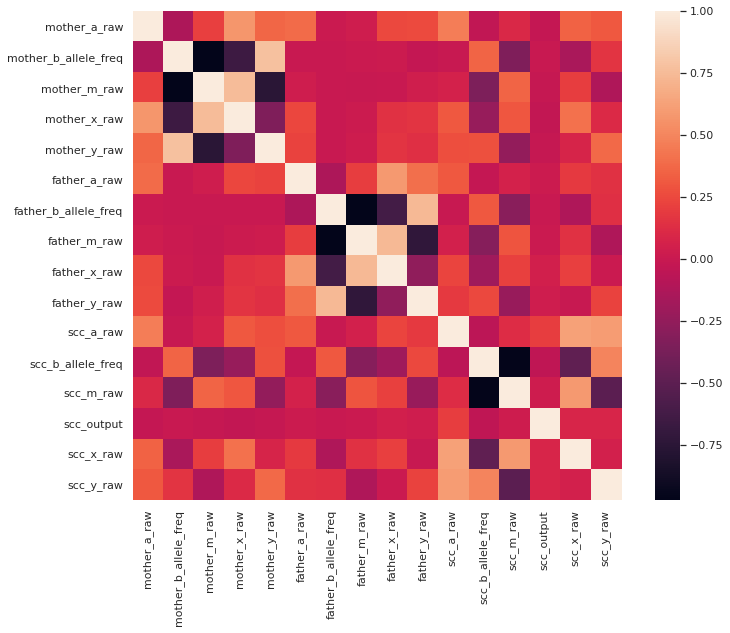

In [62]:
#columns_to_test=['scc_b_allele_freq','scc_x_raw','scc_y_raw','scc_m_raw','scc_a_raw','scc_output']
corrmat = training_balanced.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, square=True);

In [63]:
# adding information about reference genotypes from the proband
training_balanced_ref_gtypes=pd.concat([training_balanced,pd.get_dummies(training_balanced['ref_proband_gtype'])],axis=1)

In [64]:
training_balanced_ref_gtypes.columns

Index(['mother_a_raw', 'mother_b_allele_freq', 'mother_gtype', 'mother_m_raw',
       'mother_x_raw', 'mother_y_raw', 'father_a_raw', 'father_b_allele_freq',
       'father_gtype', 'father_m_raw', 'father_x_raw', 'father_y_raw',
       'scc_a_raw', 'scc_b_allele_freq', 'scc_gtype', 'scc_m_raw',
       'scc_output', 'scc_x_raw', 'scc_y_raw', 'ref_proband_gtype', 'AA', 'AB',
       'BB'],
      dtype='object')

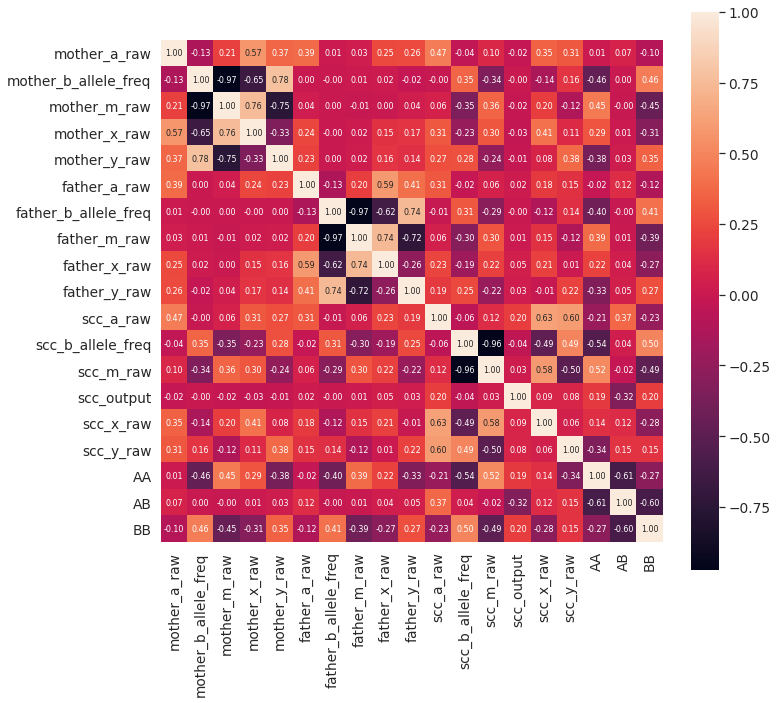

In [65]:
plt.figure(figsize=(10, 16))

#training_balanced_ref_gtypes.scc_output=training_balanced_ref_gtypes.scc_output.apply(int)
cols=[c for c in training_balanced_ref_gtypes.columns if 'gtype' not in c]
cm = np.corrcoef(training_balanced_ref_gtypes[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 8}, yticklabels=cols, xticklabels=cols,cbar_kws={"fraction": 0.05})

plt.show()

The target variable for the classification is the genotype. We therefore rank correlations of available features with the ref. genotype.

In [66]:
cormat=training_balanced_ref_gtypes.corr()
for allele in ['AB','BB','AA']:
    allele_cors=(cormat[[allele]]).apply(abs).sort_values(by=allele,ascending=False)
    print(allele_cors[allele_cors[allele]>0.07])

                    AB
AB            1.000000
AA            0.605006
BB            0.600457
scc_a_raw     0.369309
scc_output    0.322651
scc_y_raw     0.154798
father_a_raw  0.122116
scc_x_raw     0.116055
mother_a_raw  0.072624
                            BB
BB                    1.000000
AB                    0.600457
scc_b_allele_freq     0.496170
scc_m_raw             0.494316
mother_b_allele_freq  0.463968
mother_m_raw          0.446839
father_b_allele_freq  0.409553
father_m_raw          0.394940
mother_y_raw          0.349356
mother_x_raw          0.308806
scc_x_raw             0.283745
father_x_raw          0.274743
AA                    0.273424
father_y_raw          0.270540
scc_a_raw             0.230542
scc_output            0.199826
scc_y_raw             0.154649
father_a_raw          0.122751
mother_a_raw          0.096220
                            AA
AA                    1.000000
AB                    0.605006
scc_b_allele_freq     0.544943
scc_m_raw             0.51

In [73]:
# input features
selected_features=['mother_a_raw',
                   'mother_b_allele_freq',
                   'mother_x_raw',
                   'mother_y_raw',
                   'father_a_raw',
                   'father_b_allele_freq',
                   'father_x_raw',
                   'father_y_raw',
                   'scc_a_raw',
                   'scc_b_allele_freq',
                   'scc_output',
                   'scc_x_raw',
                   'scc_y_raw',
                   'ref_proband_gtype']

# output feature
output_features=['ref_proband_gtype']

## Feature scaling

Many classification algorithms require standarized values.

In [74]:
training_balanced[selected_features].describe()

,mother_a_raw,mother_b_allele_freq,mother_x_raw,mother_y_raw,father_a_raw,father_b_allele_freq,father_x_raw,father_y_raw,scc_a_raw,scc_b_allele_freq,scc_output,scc_x_raw,scc_y_raw
count,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000
mean,0.499786,0.500538,0.495142,0.495062,0.500189,0.499117,0.494752,0.496199,0.499845,0.516610,0.500000,0.494628,0.494183
std,0.276655,0.397964,0.279251,0.278200,0.276327,0.397713,0.277605,0.277883,0.277348,0.382152,0.500001,0.280155,0.279137
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.249399,0.023145,0.234256,0.232858,0.249405,0.023002,0.232979,0.232251,0.253249,0.110576,0.000000,0.246166,0.242863
50%,0.498859,0.494753,0.500244,0.500072,0.496535,0.491512,0.501437,0.501491,0.498991,0.527545,0.500000,0.492980,0.497051
75%,0.746256,0.984184,0.745171,0.746196,0.747639,0.983248,0.743412,0.744105,0.748256,0.919351,1.000000,0.745509,0.746173
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [75]:
qt = QuantileTransformer(n_quantiles=10, random_state=0)
for c in training_balanced.columns:
    if 'a_raw' in c or 'x_raw'  in c or 'y_raw' in c:
        training_balanced[c]=qt.fit_transform(training_balanced[[c]])

In [76]:
training_balanced[selected_features].describe()

,mother_a_raw,mother_b_allele_freq,mother_x_raw,mother_y_raw,father_a_raw,father_b_allele_freq,father_x_raw,father_y_raw,scc_a_raw,scc_b_allele_freq,scc_output,scc_x_raw,scc_y_raw
count,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000,244404.000000
mean,0.499786,0.500538,0.495142,0.495062,0.500189,0.499117,0.494752,0.496199,0.499845,0.516610,0.500000,0.494628,0.494183
std,0.276655,0.397964,0.279251,0.278200,0.276327,0.397713,0.277605,0.277883,0.277348,0.382152,0.500001,0.280155,0.279137
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.249399,0.023145,0.234256,0.232858,0.249405,0.023002,0.232979,0.232251,0.253249,0.110576,0.000000,0.246166,0.242863
50%,0.498859,0.494753,0.500244,0.500072,0.496535,0.491512,0.501437,0.501491,0.498991,0.527545,0.500000,0.492980,0.497051
75%,0.746256,0.984184,0.745171,0.746196,0.747639,0.983248,0.743412,0.744105,0.748256,0.919351,1.000000,0.745509,0.746173
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Visualisations of selected features


<AxesSubplot:xlabel='scc_a_raw', ylabel='Count'>

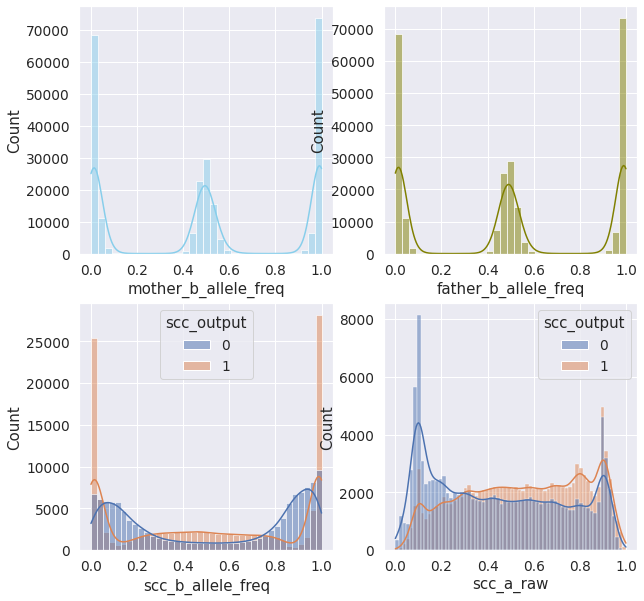

In [77]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

sns.histplot(data=training_balanced, x="mother_b_allele_freq", kde=True, color="skyblue", ax=axs[0, 0])
sns.histplot(data=training_balanced, x="father_b_allele_freq", kde=True, color="olive", ax=axs[0, 1])
sns.histplot(data=training_balanced, x="scc_b_allele_freq", hue='scc_output', kde=True, color="gold", ax=axs[1, 0])
sns.histplot(data=training_balanced, x="scc_a_raw", hue='scc_output',kde=True, color="teal", ax=axs[1, 1])

<AxesSubplot:xlabel='scc_a_raw', ylabel='scc_m_raw'>

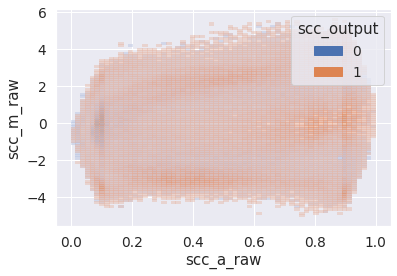

In [78]:
sns.histplot(data=training_balanced,y='scc_m_raw',x='scc_a_raw',hue='scc_output',alpha=0.5)

Text(0.5, 0, 'Mother')

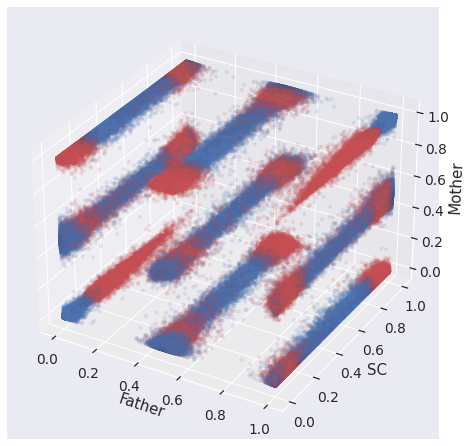

In [79]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
#ax.scatter(a_test['father_b_allele_freq'], a_test['scc_b_allele_freq'], a_test['mother_b_allele_freq'], s=10, c=['r' if i==0 else 'b' for i in a_test['scc_output']], marker='o', cmap=cmap, alpha=0.1)
ax.scatter(training_balanced['father_b_allele_freq'], training_balanced['scc_b_allele_freq'], training_balanced['mother_b_allele_freq'], s=10, c=['r' if i==0 else 'b' for i in training_balanced['scc_output']], marker='o', cmap=cmap, alpha=0.1)
ax.set_xlabel('Father')
ax.set_ylabel('SC')
ax.set_zlabel('Mother')

Text(0.5, 0, 'Mother')

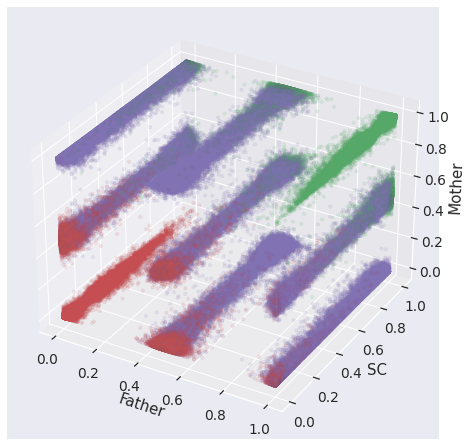

In [80]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
#ax.scatter(a_test['father_b_allele_freq'], a_test['scc_b_allele_freq'], a_test['mother_b_allele_freq'], s=10, c=['r' if i==0 else 'b' for i in a_test['scc_output']], marker='o', cmap=cmap, alpha=0.1)
ax.scatter(training_balanced_ref_gtypes['father_b_allele_freq'], 
           training_balanced_ref_gtypes['scc_b_allele_freq'], 
           training_balanced_ref_gtypes['mother_b_allele_freq'], 
           s=10, c=['r' if i=='AA' else 'g' if  i=='BB' else 'm' for i in training_balanced_ref_gtypes['ref_proband_gtype']], marker='o', cmap=cmap, alpha=0.1)
ax.set_xlabel('Father')
ax.set_ylabel('SC')
ax.set_zlabel('Mother')